# NeRF: Neural Radiance Field

This is my implementation of the NeRF algorithm, using Pytorch

References:
- [Project Website](http://www.matthewtancik.com/nerf)
- [arXiv Paper](https://arxiv.org/abs/2003.08934)



In [1]:
import numpy as np
import copy
import open3d as o3d
import matplotlib.pyplot as plt
from utils import *

# for interactive control
from ipywidgets import interact
from ipywidgets import FloatSlider
from ipywidgets import IntSlider

# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# CUDA
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')



CUDA is available. Device:  NVIDIA GeForce RTX 3070


## Load example mesh

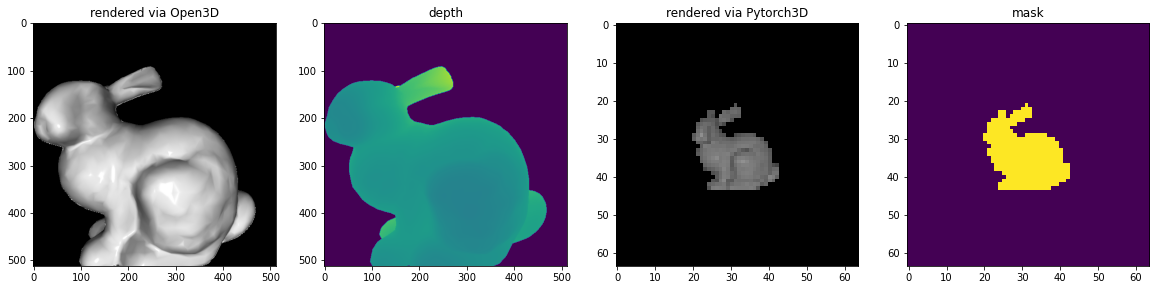

In [2]:
# load an example 3D mesh
V, T, Faces = load_obj('./data/bunny.obj')

# standardize
V_min = V.min(axis=0)
V_max = V.max(axis=0)
V = (V - V_min) / (V_max - V_min)

# re-center at the origin
V -= [0.5, 0.5, 0.5]

mesh = o3d_form_mesh(V, T, Faces)

img, dpt = o3d_render(mesh, width=512, height=512, normal=False)

# mask the background
mask = dpt > 0
for c in range(3):
    img[...,c] *= mask

plt.figure(figsize=(20,5))
plt.subplot(1,4,1); plt.title('rendered via Open3D'); plt.imshow(img)
plt.subplot(1,4,2); plt.title('depth'); plt.imshow(dpt)


# Pytorch3D renderer
lights = PointLights(device=device, location=[[0.0, 0.0, 1e5]], ambient_color=[[0.5, 0.5, 0.5]],
                    specular_color=[[.3, .3, .3]], diffuse_color=[[.5, .5, .5]])
renderer = create_pytorch3d_renderer(device, radius=4, elevation=0, azimuth=0, fov=40.0, width=64, lights=lights)

# Pytorch3D mesh object
T = np.ones(V.shape, dtype=np.float32)*0.5 # gray color
meshes = pytorch3d_mesh(device, V, T, Faces)

# render
rendered = renderer(meshes)[0]
img = rendered[...,:3].cpu().numpy()
mask = rendered[...,3].cpu().numpy() > 0
for c in range(3):
    img[...,c] *= mask

plt.subplot(1,4,3); plt.title('rendered via Pytorch3D'); plt.imshow(img)
plt.subplot(1,4,4); plt.title('mask'); plt.imshow(mask)
plt.show()


## Interact with distance, elevation, and azimuth

In [32]:
# Distance
trans_t = lambda t : np.array(
    [[1,0,0,0],
     [0,1,0,0],
     [0,0,1,t],
     [0,0,0,1]], dtype=np.float32)

# Elevation
rot_phi = lambda phi : np.array(
    [[1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]], dtype=np.float32)

# Azimuth
rot_theta = lambda th : np.array(
    [[np.cos(th),0,-np.sin(th),0],
     [0,1,0,0],
     [np.sin(th),0, np.cos(th),0],
     [0,0,0,1]], dtype=np.float32)

def pose_matrix(radius, phi, theta):
    # phi and th should be in 0 ~ 2pi
    #pose = trans_t(t) @ rot_phi(phi) @ rot_theta(th)
    pose = trans_t(radius)
    pose = rot_phi(phi/180. * np.pi) @ pose
    pose = rot_theta(theta/180. * np.pi) @ pose
    pose = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=np.float32) @ pose
    return pose

T = np.ones(V.shape, dtype=np.float32)*0.5 # gray color
@interact(t = FloatSlider(min=0, max=2.0, step=0.02),
          phi = FloatSlider(min=-3.14/2, max=3.14/2, step=0.1), 
          th = FloatSlider(min=0, max=3.14, step=0.1))
def interactive_render(t, phi, th):
    pose = pose_matrix(t, phi, th)
    # Pytorch3D mesh object
    meshes = pytorch3d_mesh(device, V @ pose[:3,:3] + pose[:3,3], T, Faces)
    # render
    rendered = renderer(meshes)[0]
    img = rendered[...,:3].cpu().numpy()
    mask = rendered[...,3].cpu().numpy() > 0
    for c in range(3):
        img[...,c] *= mask
    plt.subplot(1,2,1); plt.title('rendered'); plt.imshow(img)
    plt.subplot(1,2,2); plt.title('mask'); plt.imshow(mask)
    


interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), FloatSlider(value=0.0, desc…

## Generate training data

samples:  245


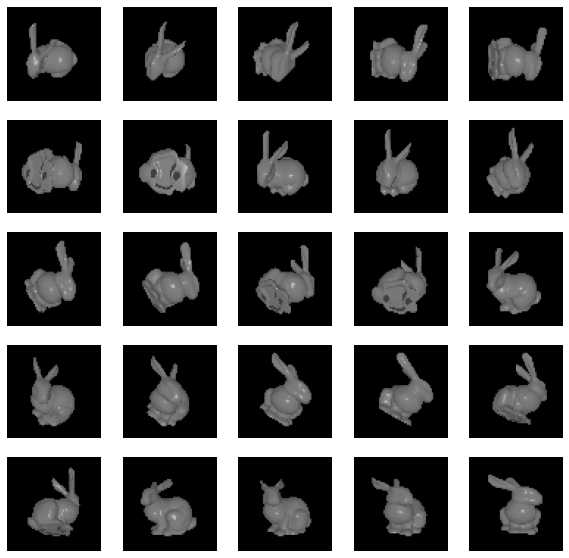

In [23]:
t_range = [1.5, 2.5]; t_step = 0.2
phi_range = [-3.14/2, 3.14/2]; phi_step = 0.5
th_range = [0, 3.14]; th_step = 0.5

# dataset
images = []
poses = []

t = t_range[0]
while t < t_range[1]:
    phi = phi_range[0]
    while phi < phi_range[1]:
        th = th_range[0]
        while th < th_range[1]:
            pose = pose_matrix(t, phi, th)
            # Pytorch3D mesh object
            meshes = pytorch3d_mesh(device, V @ pose[:3,:3] + pose[:3,3], T, Faces)
            # render
            rendered = renderer(meshes)[0]
            img = rendered[...,:3].cpu().numpy()
            mask = rendered[...,3].cpu().numpy() > 0
            for c in range(3):
                img[...,c] *= mask
            
            images.append(img)
            poses.append(pose)
                
            th += th_step
        phi += phi_step
    t += t_step
    
images = np.array(images)
poses = np.array(poses)
    
print("samples: ", len(images))
    
# display first 25 samples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')


## NeRF model

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


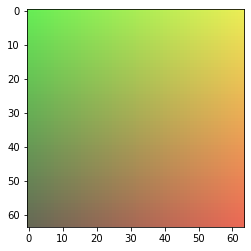

In [4]:
def posenc(x, n_freq_components):
    """positional encoding"""
    rets = [x]
    for i in range(n_freq_components):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.cat(rets, -1)

## define the MLP network
class MLP(nn.Module):
    def __init__(self, n_freq_components):
        super(MLP, self).__init__()
        self.input_dim = 3 + 3 * 2 * n_freq_components # (xyz); n * sin(x,y,z); n * cos(xyz)
        self.n_layers = 3
        self.layers = nn.ModuleList()
        self.input = nn.Linear(self.input_dim, 64)
        for l in range(self.n_layers):
            self.layers.append(nn.Linear(64+self.input_dim, 64))
        self.output = nn.Linear(64, 4) # output: RGBA value
        
    def forward(self, pos_encoding):
        inputs = pos_encoding
        h = self.input(inputs)
        for l in range(self.n_layers):
            layer = self.layers[l]
            h = torch.cat([h, inputs], 1)
            h = F.relu(layer(h))
        outputs = self.output(h)
        return outputs

dirs = None
def cast_rays(device, height, width, focal, pose):
    global dirs # make it global to prevent repeated computation

    """generate the rays origined at camera location"""
    if dirs is None:
        grid_x, grid_y = torch.meshgrid(torch.range(start=0, end=width-1, dtype=torch.float32),
                                        torch.range(start=0, end=height-1, dtype=torch.float32))
        grid_x = grid_x.to(device)
        grid_y = grid_y.to(device)
        grid_x = grid_x.t()
        grid_y = grid_y.t()
    
        H = torch.tensor(height, dtype=torch.float32).to(device)
        W = torch.tensor(width, dtype=torch.float32).to(device)
        Focal = torch.tensor(focal, dtype=torch.float32).to(device)

        # ones_like: return an array of ones with the same shape and type as a given array.
        dirs = torch.stack([(grid_x-W*.5)/Focal, 
                            -(grid_y-H*.5)/Focal, 
                            -torch.ones_like(grid_x).to(device)], -1).to(device)

    # direction of rays
    rays_d = torch.sum(dirs[..., None, :] * pose[:3,:3], -1)
    
    # origin of rays (same for each ray)
    rays_o = torch.broadcast_to(pose[:3,-1], rays_d.shape)

    return rays_o, rays_d


def volume_rendering(network, rays_o, rays_d, near, far, n_samples, n_freq_components, chunk, rand_sampling=False):
    
    n_samples = torch.tensor(n_samples, dtype=torch.int64).to(device)
    near = torch.tensor(near, dtype=torch.float32).to(device)
    far = torch.tensor(far, dtype=torch.float32).to(device)

    def batchify(fn, chunk=chunk):
        return lambda inputs : torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0).to(device)
    
    # sample 3D query point locations
    z_vals = torch.linspace(near, far, n_samples).to(device) 
    if rand_sampling:
        # random sample points during training!
        z_rand = torch.rand(list(rays_o.shape[:-1]) + [int(n_samples)]).to(device) * (far-near)/n_samples # shape: [H,W,n_samples]
        z_vals_rand = torch.ones([rays_o.shape[0],rays_o.shape[1],int(n_samples)]).to(device) * z_vals # [H,W,n_samples]
        z_vals_rand = z_vals_rand + z_rand
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # run network
    pts_flat = torch.reshape(pts, [-1,3])
    pts_flat = posenc(pts_flat, n_freq_components)
    raw = batchify(network)(pts_flat)
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # compute opacities and colors
    sigma_a = F.relu(raw[...,3])
    rgb = torch.sigmoid(raw[...,:3]) 
    
    # do volume rendering
    max_ = torch.tensor([1e10], dtype=torch.float32).to(device)
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1], torch.broadcast_to(max_, z_vals[...,:1].shape)], -1) 
    alpha = 1.-torch.exp(-sigma_a * dists)  
    weights = alpha * torch.cumprod(1.-alpha + 1e-10, -1) # cumulative product
    
    rgb_map = torch.sum(weights[...,None] * rgb, dim=-2) 
    depth_map = torch.sum(weights * z_vals, dim=-1) 
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, acc_map


# test cast_rays function
ro, rd = cast_rays(device, 64, 64, 40, torch.tensor(np.eye(4),dtype=torch.float32).to(device))
plt.imshow((rd.detach().cpu().numpy()+2)/3)


# Train on generated data

<Figure size 432x288 with 0 Axes>

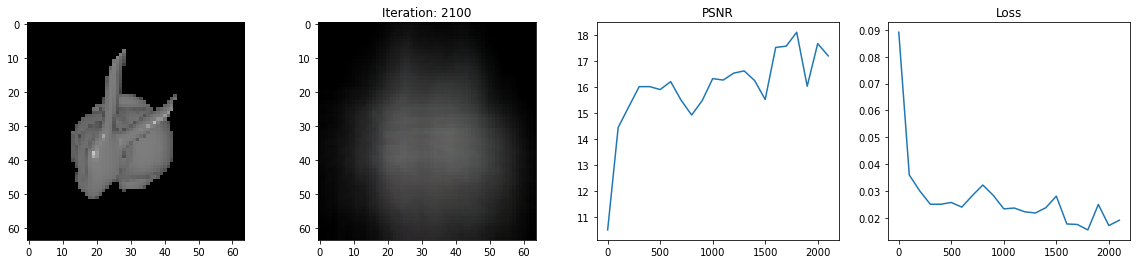

KeyboardInterrupt: 

In [24]:
from IPython.display import clear_output

n_freq_components = 6
n_samples = 64
chunk = 1024*8
n_iters = 10000
plot_step = 100
height = width = 64
focal = 40.0
near = 2.0
far = 6.0

dirs = None
mlp = MLP(n_freq_components=n_freq_components).to(device)

parameters = mlp.parameters()
optimizer = torch.optim.Adam(parameters, lr=5e-4)

log = {'iter':[], 'psnr': [], 'loss':[]}

# training loop
for iter in range(n_iters):

    # clean gradient
    optimizer.zero_grad()

    # randomly pick an image from the dataset
    img_idx = np.random.randint(images.shape[0])
    targ_img = torch.from_numpy(images[img_idx]).to(device)
    pose = torch.from_numpy(poses[img_idx]).to(device)

    # compute the rays casted from camera
    ro, rd = cast_rays(device, height, width, focal, pose)

    # render
    rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=chunk, rand_sampling=True)

    # compute loss
    loss = torch.mean(torch.square(rgb - targ_img))

    # optimize
    loss.backward()
    optimizer.step()

    # plot result
    if iter % plot_step == 0:
        
        test_img = torch.from_numpy(images[50]).to(device)
        test_pose = torch.from_numpy(poses[50]).to(device)

        ro, rd = cast_rays(device, height, width, focal, test_pose)
        
        rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=chunk, rand_sampling=False)
        loss = torch.mean(torch.square(rgb - test_img))

        # log
        psnr = -10. * np.log(loss.detach().cpu().numpy()) / np.log(10.)
        log['psnr'].append(psnr)
        log['iter'].append(iter)
        log['loss'].append(loss.detach().cpu().numpy())
        
        # plot
        plt.close()
        plt.cla()
        plt.clf()
        clear_output(wait=True)
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        plt.imshow(test_img.detach().cpu().numpy())
        plt.subplot(142)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {iter}')
        plt.subplot(143)
        plt.plot(log['iter'], log['psnr'])
        plt.title('PSNR')
        plt.subplot(144)
        plt.plot(log['iter'], log['loss'])
        plt.title('Loss')
        plt.show()



## Interactive

In [29]:
@interact(radius = FloatSlider(min=5.0, max=8.0, step=0.02),
          phi = FloatSlider(min=-90, max=90, step=0.1), 
          theta = FloatSlider(min=0, max=360, step=0.1))
def interactive_nerf(radius, phi, theta):
    
    # prepare camera pose matrix
    pose = trans_t(radius)
    pose = rot_phi(phi/180. * np.pi) @ pose
    pose = rot_theta(theta/180. * np.pi) @ pose
    pose = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=np.float32) @ pose
    pose = torch.from_numpy(pose).to(device)

    # render        
    ro, rd = cast_rays(device, height, width, focal, pose)
    rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=1024, rand_sampling=False)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1); plt.title('rendered'); plt.imshow(rgb.detach().cpu().numpy())
    plt.subplot(1,3,2); plt.title('depth'); plt.imshow(depth.detach().cpu().numpy())
    plt.subplot(1,3,3); plt.title('acc'); plt.imshow(acc.detach().cpu().numpy())

interactive(children=(FloatSlider(value=5.0, description='radius', max=8.0, min=5.0, step=0.02), FloatSlider(v…

# Train on the "excavator" data

<Figure size 432x288 with 0 Axes>

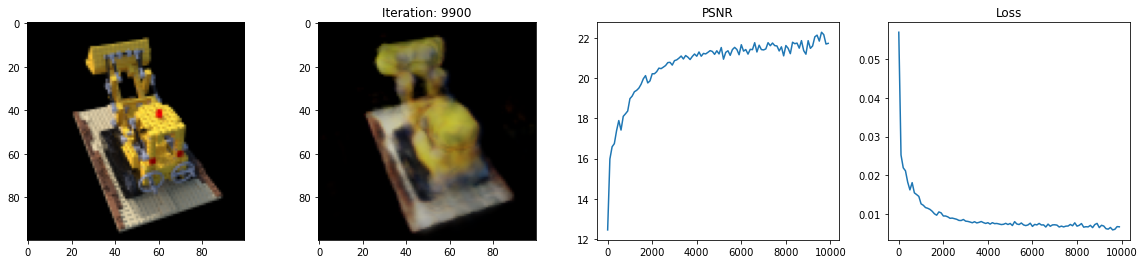

In [7]:
from IPython.display import clear_output

# load data
data = np.load('./data/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
print('focal {}'.format(data['focal']))


n_freq_components = 6
n_samples = 64
chunk = 1024*8
n_iters = 10000
plot_step = 100
height = width = 100
focal = 138.89
near = 2.0
far = 6.0

dirs = None
mlp = MLP(n_freq_components=n_freq_components).to(device)

parameters = mlp.parameters()
optimizer = torch.optim.Adam(parameters, lr=5e-4)

log = {'iter':[], 'psnr': [], 'loss':[]}

# training loop
for iter in range(n_iters):

    # clean gradient
    optimizer.zero_grad()

    # randomly pick an image from the dataset
    img_idx = np.random.randint(images.shape[0])
    targ_img = torch.from_numpy(images[img_idx]).to(device)
    pose = torch.from_numpy(poses[img_idx]).to(device)

    # compute the rays casted from camera
    ro, rd = cast_rays(device, height, width, focal, pose)

    # render
    rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=chunk, rand_sampling=True)

    # compute loss
    loss = torch.mean(torch.square(rgb - targ_img))

    # optimize
    loss.backward()
    optimizer.step()

    # plot result
    if iter % plot_step == 0:
        
        test_img = torch.from_numpy(images[50]).to(device)
        test_pose = torch.from_numpy(poses[50]).to(device)

        ro, rd = cast_rays(device, height, width, focal, test_pose)
        
        rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=chunk, rand_sampling=False)
        loss = torch.mean(torch.square(rgb - test_img))

        # log
        psnr = -10. * np.log(loss.detach().cpu().numpy()) / np.log(10.)
        log['psnr'].append(psnr)
        log['iter'].append(iter)
        log['loss'].append(loss.detach().cpu().numpy())
        
        # plot
        plt.close()
        plt.cla()
        plt.clf()
        clear_output(wait=True)
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        plt.imshow(test_img.detach().cpu().numpy())
        plt.subplot(142)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {iter}')
        plt.subplot(143)
        plt.plot(log['iter'], log['psnr'])
        plt.title('PSNR')
        plt.subplot(144)
        plt.plot(log['iter'], log['loss'])
        plt.title('Loss')
        plt.show()





In [8]:
# save parameters
#torch.save(mlp.state_dict(), './data/nerf_excavator')

# load trained model
n_freq_components = 6
n_samples = 64
chunk = 1024*8
height = width = 100
focal = 138.89
near = 2.0
far = 6.0
dirs = None
mlp = MLP(n_freq_components=n_freq_components).to(device)
mlp.load_state_dict(torch.load('./data/nerf_excavator'))
mlp.eval()


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=103, out_features=64, bias=True)
    (1): Linear(in_features=103, out_features=64, bias=True)
    (2): Linear(in_features=103, out_features=64, bias=True)
  )
  (input): Linear(in_features=39, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=4, bias=True)
)

## Interactive

In [16]:
@interact(radius = FloatSlider(min=3, max=5.0, step=0.02),
          phi = FloatSlider(min=-90, max=0, step=0.1), 
          theta = FloatSlider(min=0, max=360, step=0.1))
def interactive_nerf(radius, phi, theta):
    
    # prepare camera pose matrix
    pose = trans_t(radius)
    pose = rot_phi(phi/180. * np.pi) @ pose
    pose = rot_theta(theta/180. * np.pi) @ pose
    pose = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=np.float32) @ pose
    pose = torch.from_numpy(pose).to(device)

    # render        
    ro, rd = cast_rays(device, height, width, focal, pose)
    rgb, depth, acc = volume_rendering(mlp, ro, rd, near, far, n_samples, n_freq_components, chunk=1024, rand_sampling=False)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1); plt.title('rendered'); plt.imshow(rgb.detach().cpu().numpy())
    plt.subplot(1,3,2); plt.title('depth'); plt.imshow(depth.detach().cpu().numpy())
    plt.subplot(1,3,3); plt.title('acc'); plt.imshow(acc.detach().cpu().numpy())
    

interactive(children=(FloatSlider(value=3.0, description='radius', max=5.0, min=3.0, step=0.02), FloatSlider(v…